In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scikeras.wrappers import KerasClassifier
from skopt import BayesSearchCV
%matplotlib inline 

In [2]:
data = pd.read_csv('churn_data.csv')
data.head()

Age  Gender  Tenure  Usage Frequency  Support Calls  Payment Delay  \
0  32.0  Female    50.0             16.0            1.0            9.0   
1  27.0  Female     5.0              1.0           10.0           29.0   
2  42.0    Male     3.0             16.0            2.0           11.0   
3  27.0  Female    35.0             29.0            1.0            2.0   
4  32.0    Male    51.0             18.0            0.0            5.0   

  Subscription Type Contract Length  Total Spend  Last Interaction  Churn  
0             Basic       Quarterly       774.06               2.0    0.0  
1           Premium          Annual       295.00              25.0    1.0  
2           Premium          Annual       623.61              25.0    0.0  
3             Basic       Quarterly       567.96              10.0    0.0  
4           Premium          Annual       831.21              11.0    0.0

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165000 entries, 0 to 164999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Age                165000 non-null  float64
 1   Gender             165000 non-null  object 
 2   Tenure             165000 non-null  float64
 3   Usage Frequency    165000 non-null  float64
 4   Support Calls      165000 non-null  float64
 5   Payment Delay      165000 non-null  float64
 6   Subscription Type  165000 non-null  object 
 7   Contract Length    165000 non-null  object 
 8   Total Spend        165000 non-null  float64
 9   Last Interaction   165000 non-null  float64
 10  Churn              165000 non-null  float64
dtypes: float64(8), object(3)
memory usage: 13.8+ MB


In [4]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 48.17it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# Separate train, test
train, test = train_test_split(data, test_size=0.2, random_state=42)

# Delete rows where 'Churn' is NaN
train = train.dropna(subset=['Churn'])

# Separar variables explicativas y variable objetivo
X_train = train.drop('Churn', axis=1)
y_train = train['Churn']

display(X_train.head())
display(y_train.head())

Age  Gender  Tenure  Usage Frequency  Support Calls  Payment Delay  \
82562  46.0    Male     8.0             28.0            4.0           10.0   
13148  42.0  Female    45.0             30.0            1.0           20.0   
10615  21.0    Male    57.0             15.0            1.0           20.0   
38965  21.0    Male    19.0             12.0            1.0            3.0   
24572  30.0    Male    57.0             23.0            1.0           14.0   

      Subscription Type Contract Length  Total Spend  Last Interaction  
82562             Basic         Monthly       238.00              12.0  
13148           Premium       Quarterly       659.30               2.0  
10615          Standard          Annual       511.55              21.0  
38965           Premium       Quarterly       890.55              14.0  
24572             Basic          Annual       553.09              18.0

82562    1.0
13148    0.0
10615    0.0
38965    0.0
24572    0.0
Name: Churn, dtype: float64

In [6]:
# Aplicar OneHotEncoder a la variable a predecir
encoder_y = OneHotEncoder(sparse_output=False)

y_train_encoded = encoder_y.fit_transform(y_train.values.reshape(-1, 1))

# Cuarto Paso: Standard Scaler para variables numericas, One hot Encoder para variables categoricas
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns
print(f'Numerical {numeric_features}')
print(f'Categorical {categorical_features}')

Numerical Index(['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay',
       'Total Spend', 'Last Interaction'],
      dtype='object')
Categorical Index(['Gender', 'Subscription Type', 'Contract Length'], dtype='object')


In [7]:
# Escalo las variables numericas y aplico OneHotEncoder a las categoricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),   
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Creo el pipeline de transformacion
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_train_processed = full_pipeline.fit_transform(X_train)

In [8]:
numerical_features = numeric_features.tolist()
categorical_features_names = full_pipeline.named_steps['preprocessor']\
                    .named_transformers_['cat']\
                    .named_steps['onehot']\
                    .get_feature_names_out(categorical_features)

all_features = numerical_features + categorical_features_names.tolist()

X_train_processed = pd.DataFrame(X_train_processed, columns = all_features)
X_train_processed.head(5)

Age    Tenure  Usage Frequency  Support Calls  Payment Delay  \
0  0.936043 -1.409817         1.398097       1.125141      -0.074045   
1  0.530251  0.751992         1.634486      -0.490064       1.452044   
2 -1.600159  1.453119        -0.138432      -0.490064       1.452044   
3 -1.600159 -0.767117        -0.493015      -0.490064      -1.142308   
4 -0.687126  1.453119         0.807124      -0.490064       0.536390   

   Total Spend  Last Interaction  Gender_Female  Gender_Male  \
0    -2.911574         -0.148554            0.0          1.0   
1    -0.422877         -1.344788            1.0          0.0   
2    -1.295663          0.928056            0.0          1.0   
3     0.943160          0.090693            0.0          1.0   
4    -1.050279          0.569186            0.0          1.0   

   Subscription Type_Basic  Subscription Type_Premium  \
0                      1.0                        0.0   
1                      0.0                        1.0   
2                      0.0                        0.0   
3                      0.0                        1.0   
4                      1.0                        0.0   

   Subscription Type_Standard  Contract Length_Annual  \
0                         0.0                     0.0   
1                         0.0                     0.0   
2                         1.0                     1.0   
3                         0.0                     0.0   
4                         0.0                     1.0   

   Contract Length_Monthly  Contract Length_Quarterly  
0                      1.0                        0.0  
1                      0.0                        1.0  
2                      0.0                        0.0  
3                      0.0                        1.0  
4                      0.0                        0.0

# Iniciamos con el modelo

In [9]:
model = Sequential(name="3HL_MLP")

model.add(Input(shape=(X_train_processed.shape[1],), name="InputLayer"))
model.add(Dense(15, activation="relu", name="HiddenLayer1"))
model.add(Dense(8, activation="relu", name="HiddenLayer2"))
model.add(Dense(4, activation="relu", name="HiddenLayer3"))
model.add(Dense(2, activation="softmax", name="OutputLayer"))

In [10]:
model.compile(
    loss="categorical_crossentropy", 
    optimizer=Adam(learning_rate=0.5),
    metrics=['accuracy', 'recall'])

model.summary()

Model: "3HL_MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ HiddenLayer1 (Dense)            │ (None, 15)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer2 (Dense)            │ (None, 8)              │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer3 (Dense)            │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputLayer (Dense)             │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 414 (1.62 KB)

 Trainable params: 414 (1.62 KB)

 Non-trainable params: 0 (0.00 B)

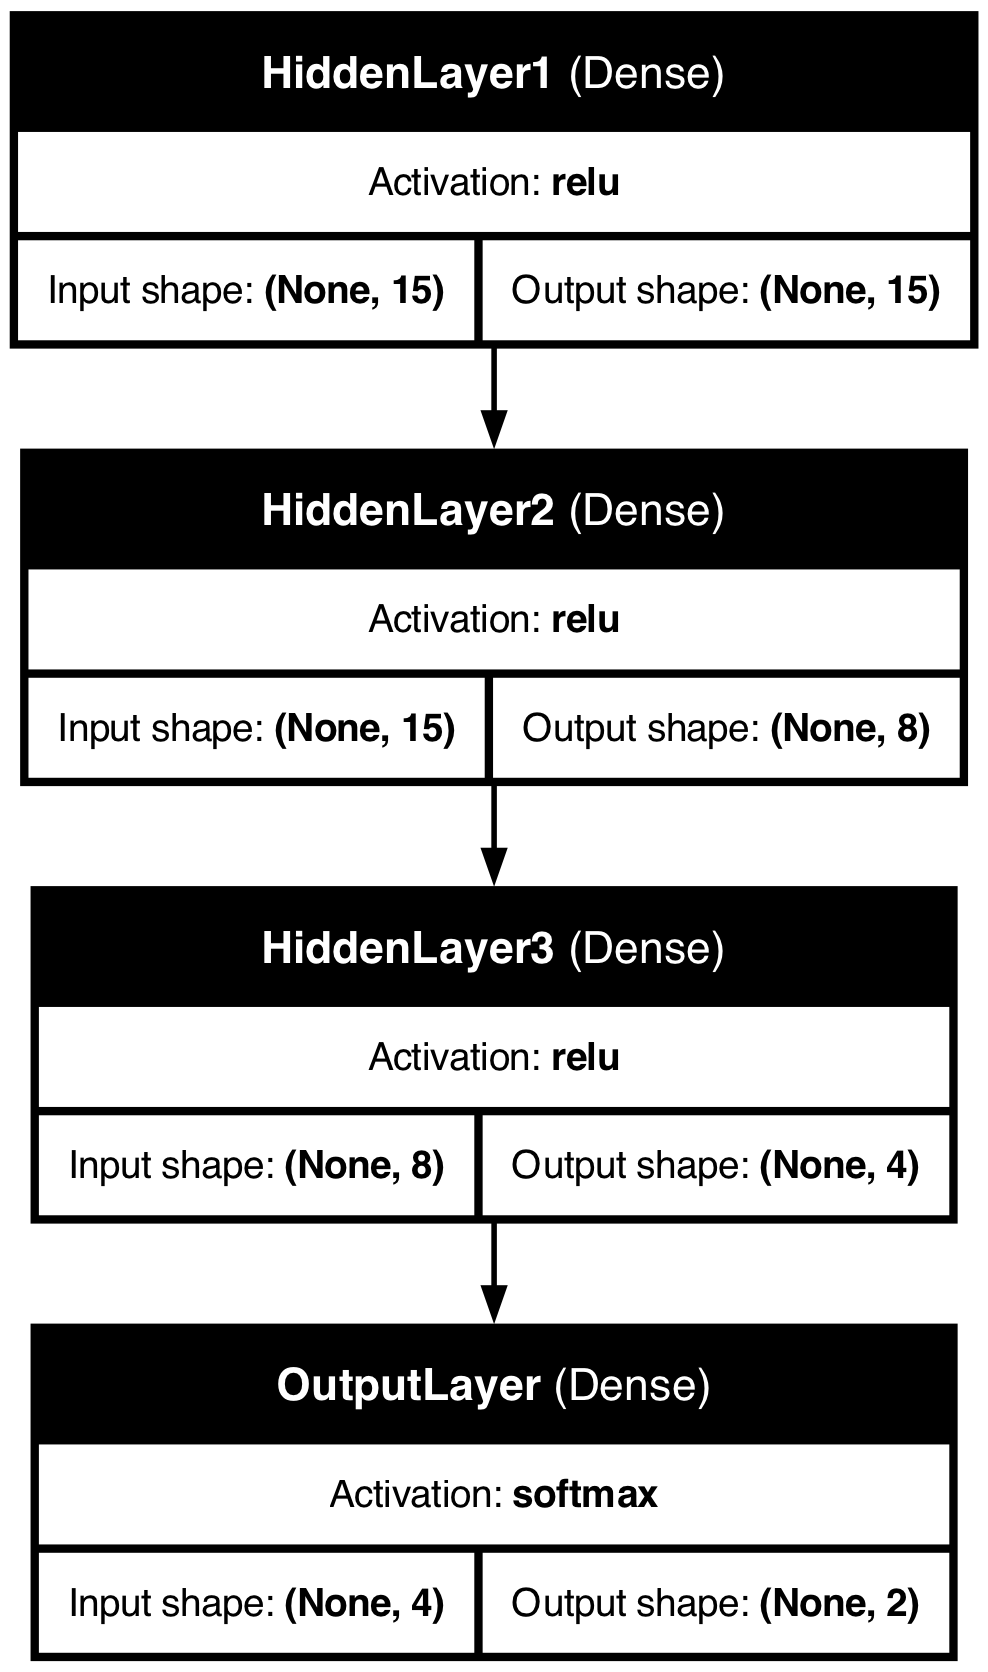

In [11]:
plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [12]:
%%time
history = model.fit(
    X_train_processed,
    y_train_encoded,
    batch_size=10,
    epochs=5
)

Epoch 1/5
13200/13200 ━━━━━━━━━━━━━━━━━━━━ 9s 575us/step - accuracy: 0.9086 - loss: 0.3385 - recall: 0.9085
Epoch 2/5
13200/13200 ━━━━━━━━━━━━━━━━━━━━ 7s 531us/step - accuracy: 0.9087 - loss: 0.3270 - recall: 0.9087
Epoch 3/5
13200/13200 ━━━━━━━━━━━━━━━━━━━━ 7s 495us/step - accuracy: 0.9087 - loss: 0.3271 - recall: 0.9087
Epoch 4/5
13200/13200 ━━━━━━━━━━━━━━━━━━━━ 7s 497us/step - accuracy: 0.9087 - loss: 0.3261 - recall: 0.9087
Epoch 5/5
13200/13200 ━━━━━━━━━━━━━━━━━━━━ 7s 503us/step - accuracy: 0.9087 - loss: 0.3248 - recall: 0.9087
CPU times: user 41.4 s, sys: 3.98 s, total: 45.4 s
Wall time: 35.8 s


In [13]:
loss, accuracy, recall = model.evaluate(X_train_processed, y_train_encoded)
print(f'Loss: {loss}, Accuracy: {accuracy}, Recall: {recall}')

4125/4125 ━━━━━━━━━━━━━━━━━━━━ 2s 440us/step - accuracy: 0.9087 - loss: 0.3242 - recall: 0.9087
Loss: 0.3241707980632782, Accuracy: 0.9086893796920776, Recall: 0.9086893796920776


In [14]:
y_pred = model.predict(X_train_processed)
y_pred_classes = y_pred.argmax(axis=1)
y_pred_classes

4125/4125 ━━━━━━━━━━━━━━━━━━━━ 1s 291us/step


array([0, 0, 0, ..., 0, 0, 0])

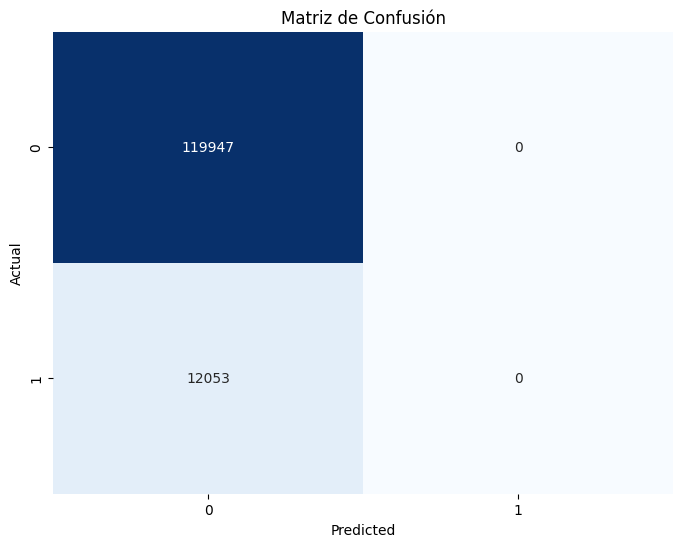

In [15]:
cm = confusion_matrix(y_train, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

In [16]:
print(classification_report(y_train, y_pred_classes))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95    119947
         1.0       0.00      0.00      0.00     12053

    accuracy                           0.91    132000
   macro avg       0.45      0.50      0.48    132000
weighted avg       0.83      0.91      0.87    132000



/Users/juandanielcastrellon/Documents/Universidad/Maestria/Semestre 3/Deep Learning/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juandanielcastrellon/Documents/Universidad/Maestria/Semestre 3/Deep Learning/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juandanielcastrellon/Documents/Universidad/Maestria/Semestre 3/Deep Learning/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-de

In [17]:
X_test, y_test = test.drop(['Churn'], axis=1), test['Churn']

display(X_test)
display(y_test)

y_test_encoded = encoder_y.transform(y_test.values.reshape(-1, 1))
display(y_test_encoded)

Age  Gender  Tenure  Usage Frequency  Support Calls  Payment Delay  \
78264   47.0    Male    11.0             24.0            0.0            9.0   
14291   20.0  Female    20.0             23.0            1.0            3.0   
35290   37.0    Male    52.0             15.0            0.0            8.0   
161283  50.0    Male     2.0             15.0            2.0           12.0   
121552  20.0    Male    57.0              7.0            0.0           10.0   
...      ...     ...     ...              ...            ...            ...   
102501  21.0    Male    57.0             29.0            0.0           18.0   
141293  45.0    Male    60.0             27.0            3.0           12.0   
113230  39.0  Female    29.0              8.0            0.0            8.0   
149231  24.0  Female    34.0             16.0            0.0           13.0   
110199  33.0    Male    57.0             18.0            3.0            1.0   

       Subscription Type Contract Length  Total Spend  Last Interaction  
78264              Basic       Quarterly       662.18              16.0  
14291           Standard          Annual       603.11               4.0  
35290           Standard       Quarterly       846.55               8.0  
161283           Premium          Annual       653.94              22.0  
121552          Standard       Quarterly       922.19              25.0  
...                  ...             ...          ...               ...  
102501          Standard          Annual       683.86              26.0  
141293             Basic       Quarterly       510.90              21.0  
113230             Basic       Quarterly       864.37               7.0  
149231          Standard       Quarterly       929.10               8.0  
110199           Premium       Quarterly       629.82              24.0  

[33000 rows x 10 columns]

78264     0.0
14291     0.0
35290     0.0
161283    0.0
121552    0.0
         ... 
102501    0.0
141293    0.0
113230    0.0
149231    0.0
110199    0.0
Name: Churn, Length: 33000, dtype: float64

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [18]:
# Apliquemos el pipeline para ahorrarnos pasos
X_test_processed = full_pipeline.transform(X_test)
X_test_processed = pd.DataFrame(X_test_processed, columns=all_features)
X_test_processed.head()

Age    Tenure  Usage Frequency  Support Calls  Payment Delay  \
0  1.037491 -1.234535         0.925319      -1.028465      -0.226654   
1 -1.701607 -0.708690         0.807124      -0.490064      -1.142308   
2  0.023010  1.160983        -0.138432      -1.028465      -0.379263   
3  1.341835 -1.760380        -0.138432       0.048338       0.231172   
4 -1.701607  1.453119        -1.083988      -1.028465      -0.074045   

   Total Spend  Last Interaction  Gender_Female  Gender_Male  \
0    -0.405864          0.329939            0.0          1.0   
1    -0.754801         -1.105541            1.0          0.0   
2     0.683244         -0.627047            0.0          1.0   
3    -0.454539          1.047679            0.0          1.0   
4     1.130064          1.406549            0.0          1.0   

   Subscription Type_Basic  Subscription Type_Premium  \
0                      1.0                        0.0   
1                      0.0                        0.0   
2                      0.0                        0.0   
3                      0.0                        1.0   
4                      0.0                        0.0   

   Subscription Type_Standard  Contract Length_Annual  \
0                         0.0                     0.0   
1                         1.0                     1.0   
2                         1.0                     0.0   
3                         0.0                     1.0   
4                         1.0                     0.0   

   Contract Length_Monthly  Contract Length_Quarterly  
0                      0.0                        1.0  
1                      0.0                        0.0  
2                      0.0                        1.0  
3                      0.0                        0.0  
4                      0.0                        1.0

In [19]:
y_pred = model.predict(X_test_processed)
y_pred_classes = y_pred.argmax(axis=1)
y_pred_classes

1032/1032 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


array([0, 0, 0, ..., 0, 0, 0])

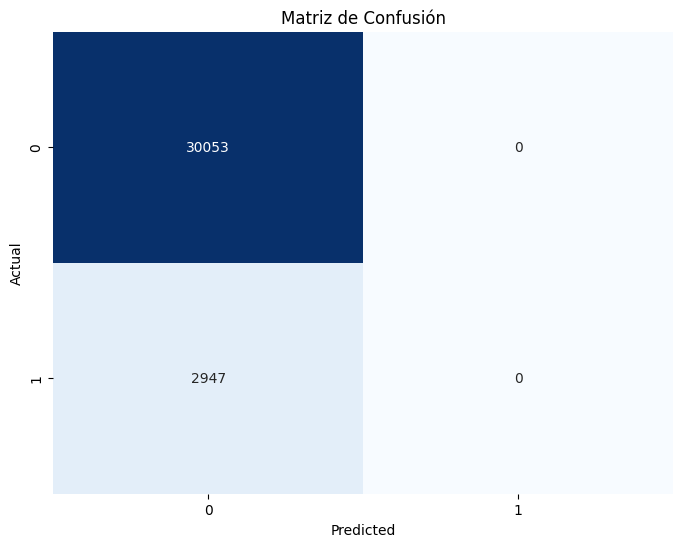

In [20]:
cm = confusion_matrix(y_test, y_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

In [21]:
def get_model(
        meta, 
        activation, 
        n_layers, 
        hidden_layer_1, 
        hidden_layer_2 = None, 
        hidden_layer_3 = None, 
        optimizer='sgd'
    ):
    n_features_in_ = meta["n_features_in_"]
    dims = [hidden_layer_1, hidden_layer_2, hidden_layer_3]

    model = Sequential(name="Red_MLP")
    model.add(Input(shape=(n_features_in_,))) # Correct input shape for processed data

    for i in range(n_layers):
        if dims[i] is not None: # Add layers only if the dimension is specified
            model.add(Dense(dims[i], activation=activation))

    model.add(Dense(2, activation='softmax')) # Corrected output layer for binary classification
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) # Necesario para agregar el callback
    return model

In [22]:
early_stopping_callback=EarlyStopping(monitor='val_accuracy', \
                                    patience=2, \
                                    restore_best_weights=True)

In [23]:
clf = KerasClassifier(
    get_model,
    loss="categorical_crossentropy",
    n_layers=2,
    hidden_layer_1=16,
    hidden_layer_2=8,
    hidden_layer_3=4,
    optimizer="sdg",
    metrics=["accuracy"],
    epochs=10,
    activation="relu",
    callbacks=[early_stopping_callback],
    validation_split=0.2
)

clf

KerasClassifier(
	model=<function get_model at 0x16ce5aac0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=sdg
	loss=categorical_crossentropy
	metrics=['accuracy']
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x16cccc320>]
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=10
	n_layers=2
	hidden_layer_1=16
	hidden_layer_2=8
	hidden_layer_3=4
	activation=relu
	class_weight=None
)

In [24]:
full_pipeline_clf=Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", clf)
])

full_pipeline_clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay',
       'Total Spend', 'Last Interaction'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImpute...
                                                  Index(['Gender', 'Subscription Type', 'Contract Length'], dtype='object'))])),
                ('clf',
                 KerasClassifier(activation='relu', callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x16cccc320>], epochs=10, hidden_layer_1=16, hidden_layer_2=8, hidden_layer_3=4, loss='categorical_crossentropy', metrics=['accuracy'], model=<function get_model at 0x16ce5aac0>, n_layers=2, optimizer='sdg', validation_split=0.2))])

In [25]:
params = {
    "clf__hidden_layer_1": [i for i in range(1, 33)],
    "clf__hidden_layer_2": [i for i in range(1, 17)],
    "clf__hidden_layer_3": [i for i in range(1, 9)],
    "clf__n_layers": [1, 2, 3],
    "clf__activation": ["relu", "linear", "sigmoid", "elu", "leaky_relu"],
    "clf__optimizer": ["adam", "sdg"],
    "clf__optimizer__learning_rate": [0.1, .5, 1, 3],
    "clf__epochs": [1, 2, 3, 4, 5],
}

grid = BayesSearchCV(full_pipeline_clf, params, cv=3, scoring="accuracy", n_iter=50, random_state=33)

In [26]:
%%time
grid.fit(X_train, y_train_encoded)

2200/2200 ━━━━━━━━━━━━━━━━━━━━ 2s 633us/step - accuracy: 0.9082 - loss: 0.3145 - val_accuracy: 0.9053 - val_loss: 0.3128
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 2s 576us/step - accuracy: 0.8851 - loss: 0.3412 - val_accuracy: 0.9053 - val_loss: 0.3127
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 2s 601us/step - accuracy: 0.8911 - loss: 0.3284 - val_accuracy: 0.9098 - val_loss: 0.2991
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
Epoch 1/4
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 1s 569us/step - accuracy: 0.9092 - loss: 0.2570 - val_accuracy: 0.9053 - val_loss: 0.2151
Epoch 2/4
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 1s 550us/step - accuracy: 0.9236 - loss: 0.1838 - val_accuracy: 0.9401 - val_loss: 0.1677
Epoch 3/4
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 1s 523us/step - accuracy: 0.9531 - loss: 0.1514 - val_accuracy: 0.9566 - val_loss: 0.1451
Epoch 4/4
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 1s 525us/step - accuracy: 0.9602 - loss: 0.1358 - val_accuracy: 0.96

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(remainder='passthrough',
                                                           transformers=[('num',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('scaler',
                                                                                           StandardScaler())]),
                                                                          Index(['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay',
       'Total Spend', 'Last Interaction'],
      dtype='object')),
                                                                         ('cat',
                                                                          Pipeline(s...
                                                 'elu', 'leaky_relu'],
                             'clf__epochs': [1, 2, 3, 4, 5],
                             'clf__hidden_layer_1': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                     10, 11, 12, 13, 14, 15, 16,
                                                     17, 18, 19, 20, 21, 22, 23,
                                                     24, 25, 26, 27, 28, 29, 30, ...],
                             'clf__hidden_layer_2': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                     10, 11, 12, 13, 14, 15,
                                                     16],
                             'clf__hidden_layer_3': [1, 2, 3, 4, 5, 6, 7, 8],
                             'clf__n_layers': [1, 2, 3],
                             'clf__optimizer': ['adam', 'sdg'],
                             'clf__optimizer__learning_rate': [0.1, 0.5, 1, 3]})

In [34]:
best_model = grid.best_estimator_

grid.best_params_

OrderedDict([('clf__activation', 'leaky_relu'),
             ('clf__epochs', 5),
             ('clf__hidden_layer_1', 27),
             ('clf__hidden_layer_2', 5),
             ('clf__hidden_layer_3', 1),
             ('clf__n_layers', 3),
             ('clf__optimizer', 'adam'),
             ('clf__optimizer__learning_rate', 0.1)])

In [35]:
y_pred = best_model.predict(X_train)
y_pred_classes = y_pred.argmax(axis=1)
y_pred_classes

4125/4125 ━━━━━━━━━━━━━━━━━━━━ 1s 273us/step


array([1, 0, 0, ..., 0, 0, 0])

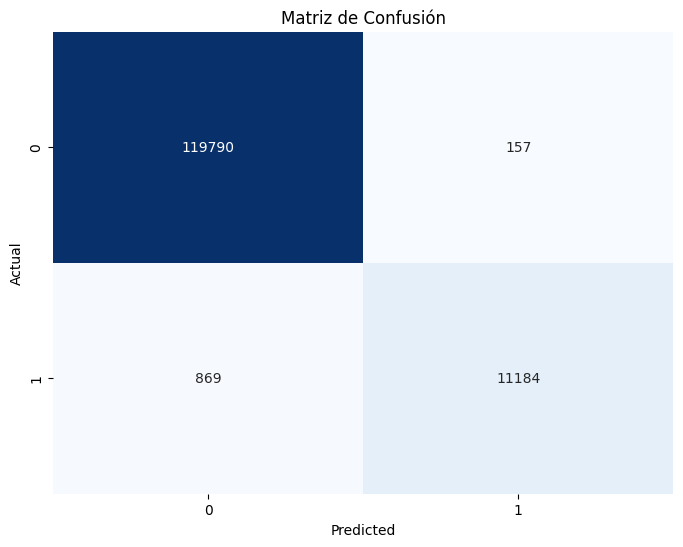

In [36]:
cm = confusion_matrix(y_train, y_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

In [37]:
print(classification_report(y_train_encoded, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    119947
           1       0.99      0.93      0.96     12053

   micro avg       0.99      0.99      0.99    132000
   macro avg       0.99      0.96      0.98    132000
weighted avg       0.99      0.99      0.99    132000
 samples avg       0.99      0.99      0.99    132000



In [38]:
y_pred = best_model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_pred_classes

1032/1032 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


array([0, 0, 0, ..., 0, 0, 0])

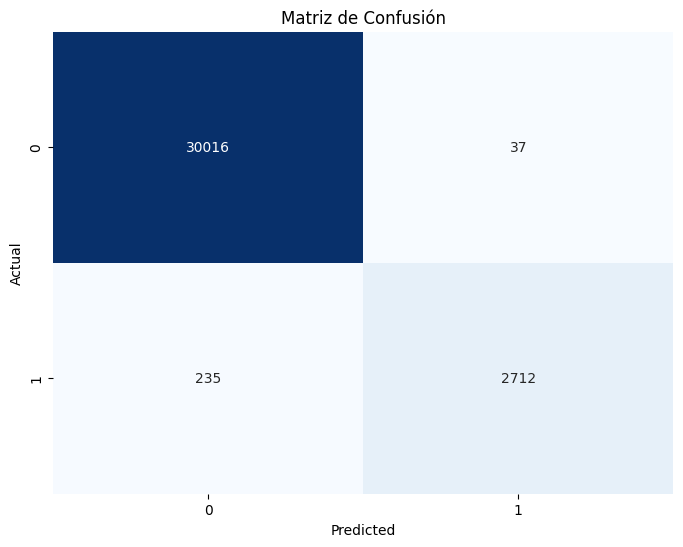

In [39]:
#y_test_classes = y_test_encoded.argmax(axis=1)

cm = confusion_matrix(y_test, y_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

In [40]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     30053
         1.0       0.99      0.92      0.95      2947

    accuracy                           0.99     33000
   macro avg       0.99      0.96      0.97     33000
weighted avg       0.99      0.99      0.99     33000

